In [1]:
# %matplotlib ipympl 
import numpy as np
import pandas as pd
import csv
import datetime
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import boxcox
from scipy.stats import yeojohnson

In [2]:
# load all data into dataframe
def load_data(path, file_names, aliases):
    dates = {}
    for data_set_idx in range(len(data_files)):
        cur_alias = aliases[data_set_idx]
        with open(path + data_files[data_set_idx] + '.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            spamreader.__next__()
            for row in spamreader:
                try:
                    cur_date = datetime.datetime.strptime(row[0], '%m/%d/%Y')

                except:
                   continue
                if not cur_date in dates:
                    dates[cur_date] = {}
                    # need to generalize here
                if data_set_idx == 0 or data_set_idx == 2:
                    dates[cur_date][cur_alias] = float(row[4])
                elif data_set_idx == 1 or data_set_idx == 3 or data_set_idx == 4 or data_set_idx == 5:
                    dates[cur_date][cur_alias] = float(row[1])

    frame = pd.DataFrame.from_dict(dates, orient='index')
    frame.columns = aliases
    frame.reset_index(inplace=True)
    frame = frame.rename(columns = {'index':'Date'})
    return frame


In [3]:
path = 'C:\\Users\\plant\\OneDrive\\Documents\\Neural Networks Project\\'
file_name_SP = 'SandPPrices'  
file_name_RE = 'RealEstateIndexDailySince2013'
file_name_BND = 'isharesBondIndexSince2003'
file_name_EU = 'USD_EURHistoricalData'
file_name_JPY = 'USD_JPYHistoricalData'
file_name_GOLD = 'GoldFuturesHistoricalData'

data_files = [file_name_SP, file_name_RE, file_name_BND, file_name_EU, file_name_JPY, file_name_GOLD]
aliases = ["sp", "re", "bnd", "eu", "jp", "gld"]

frame = load_data(path, data_files, aliases)

In [4]:
frame

,Date,sp,re,bnd,eu,jp,gld
0,2000-01-03,1455.22,0.9743,101.59,NaN,NaN,NaN
1,2000-01-04,1399.42,0.9700,103.27,283.7,NaN,NaN
2,2000-01-05,1402.11,0.9693,104.29,282.1,NaN,NaN
3,2000-01-06,1403.45,0.9688,105.33,282.4,NaN,NaN
4,2000-01-07,1441.47,0.9717,105.36,282.9,NaN,NaN
...,...,...,...,...,...,...,...
8568,2013-03-24,NaN,NaN,NaN,NaN,NaN,267.32
8569,2013-03-30,NaN,NaN,NaN,NaN,NaN,270.11
8570,2013-03-31,NaN,NaN,NaN,NaN,NaN,270.11
8571,2013-04-06,NaN,NaN,NaN,NaN,NaN,274.51


In [5]:
not_null = frame.query("sp.notnull() and re.notnull()")
not_null.reset_index(drop = True, inplace = True)
not_null

sp_not_null = frame.query("sp.notnull()")
sp_not_null.reset_index(drop = True, inplace = True)

In [6]:
prev_month = [[] for i in range(len(aliases))]
next_2wks = [[] for i in range(len(aliases))]

for idx, row in sp_not_null.iterrows():
    for alias_idx, asset in enumerate(aliases):
        if idx + 10 < sp_not_null.shape[0] and idx > 20:
            cur_price = row[asset]
            last_month = sp_not_null.loc[idx - 21].at[asset]
            fut_2wk = sp_not_null.loc[idx + 10].at[asset]
            prev_month[alias_idx].append((cur_price - last_month)/last_month)
            next_2wks[alias_idx].append((fut_2wk - cur_price)/cur_price)              
        else:
            prev_month[alias_idx].append(None)
            next_2wks[alias_idx].append(None)
            
            
for idx, asset in enumerate(aliases):
    last_month_name = asset + "_last_month"
    fut_2wks_name = asset + "_fut_2wks"
    sp_not_null.insert(sp_not_null.shape[1], last_month_name, prev_month[idx], True)
    sp_not_null.insert(sp_not_null.shape[1], fut_2wks_name, next_2wks[idx], True)
    

In [7]:
for idx, aliase in enumerate(aliases):
    for idx2, aliase2 in enumerate(aliases[idx + 1: ]):
        sp_not_null.insert(sp_not_null.shape[1], aliase2 + "_" + aliase + "_2wk_diff", sp_not_null[aliase2 + "_fut_2wks"]  - sp_not_null[aliase + "_fut_2wks"], True)
#         if idx > 1:
#             sp_not_null.insert(sp_not_null.shape[1], aliase + "_re_2wk_diff", sp_not_null[aliase + "_fut_2wks"]  - sp_not_null["re_fut_2wks"], True)

In [8]:
sp_not_null[40:300]

,Date,sp,re,bnd,eu,jp,gld,sp_last_month,sp_fut_2wks,re_last_month,...,bnd_re_2wk_diff,eu_re_2wk_diff,jp_re_2wk_diff,gld_re_2wk_diff,eu_bnd_2wk_diff,jp_bnd_2wk_diff,gld_bnd_2wk_diff,jp_eu_2wk_diff,gld_eu_2wk_diff,gld_jp_2wk_diff
40,2000-03-01,1379.19,1.0270,107.14,293.3,NaN,NaN,-0.010950,0.009397,-0.004169,...,-0.020143,-0.018944,NaN,NaN,0.001199,NaN,NaN,NaN,NaN,NaN
41,2000-03-02,1381.76,1.0368,107.78,289.7,NaN,NaN,-0.019528,0.055516,0.008364,...,-0.013549,-0.002086,NaN,NaN,0.011463,NaN,NaN,NaN,NaN,NaN
42,2000-03-03,1409.17,1.0415,107.76,290.3,NaN,NaN,0.000035,0.039243,0.016891,...,0.002927,-0.005679,NaN,NaN,-0.008606,NaN,NaN,NaN,NaN,NaN
43,2000-03-06,1391.28,1.0426,107.43,289.4,NaN,NaN,-0.023643,0.046971,0.032789,...,0.005271,0.004558,NaN,NaN,-0.000712,NaN,NaN,NaN,NaN,NaN
44,2000-03-07,1355.62,1.0423,106.11,293.7,NaN,NaN,-0.048267,0.101983,0.024877,...,0.011865,-0.006439,NaN,NaN,-0.018304,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2001-03-06,1253.80,1.0703,118.90,260.9,NaN,NaN,-0.070894,-0.088674,0.002154,...,0.001052,-0.027759,NaN,NaN,-0.028811,NaN,NaN,NaN,NaN,NaN
296,2001-03-07,1261.89,1.0757,120.04,262.4,NaN,NaN,-0.068241,-0.110747,0.009573,...,-0.010467,-0.038970,NaN,NaN,-0.028503,NaN,NaN,NaN,NaN,NaN
297,2001-03-08,1264.74,1.0726,119.74,266.1,NaN,NaN,-0.064721,-0.116356,-0.002140,...,-0.017854,-0.067168,NaN,NaN,-0.049314,NaN,NaN,NaN,NaN,NaN
298,2001-03-09,1233.42,1.0715,119.54,271.5,NaN,NaN,-0.080148,-0.075878,-0.005384,...,-0.022169,-0.084533,NaN,NaN,-0.062363,NaN,NaN,NaN,NaN,NaN


21      0.026687
22      0.054201
23      0.090032
24      0.070567
25      0.072003
          ...   
5772   -0.004843
5773    0.010058
5774    0.050705
5775    0.018394
5776   -0.033834
Name: bnd_sp_2wk_diff, Length: 5756, dtype: float64
-0.001790407564081569
0.036379834795332015
-0.003302156418131298
0.036051054051671104


<Figure size 640x480 with 0 Axes>

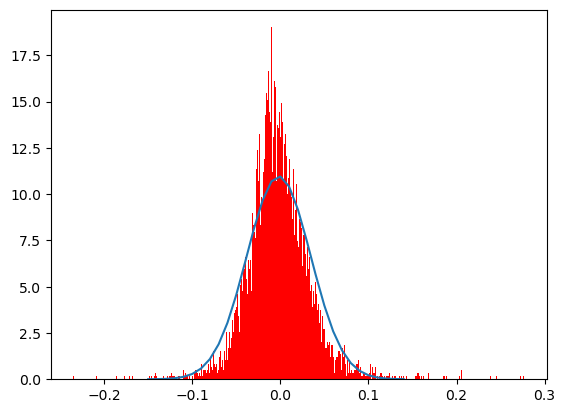

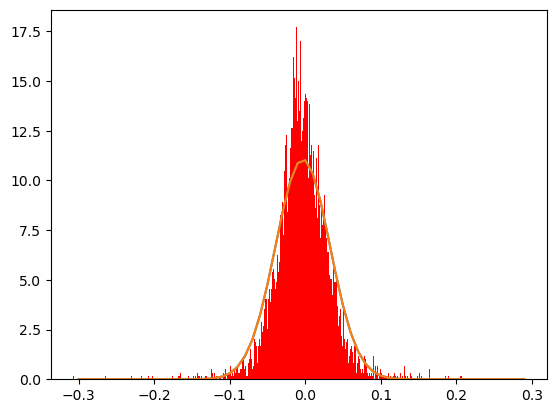

In [9]:

#use sklearn.preprocessing.PowerTransformer instead

plt.figure()

column_name = 'bnd_sp_2wk_diff'
column = sp_not_null[column_name] 
column = column[~np.isnan(column)]
print(column)
# column += np.array([1 for i in range(len(column))])
# print(column)
plt.figure()
plt.hist(column , color = 'red', bins = 500, density=True)
mean = np.mean(column)
std = np.std(column)
print(mean)
print(std)
x_axis = np.arange(-.15, .15, 0.01)

plt.plot(x_axis, norm.pdf(x_axis, mean, std))


plt.figure()
plt.hist(yeojohnson(column)[0] , color = 'red', bins = 500, density=True)
mean = np.mean(yeojohnson(column)[0])
std = np.std(yeojohnson(column)[0])
print(mean)
print(std)
x_axis = np.arange(-.3, .3, 0.01)

plt.plot(x_axis, norm.pdf(x_axis, mean, std))
# plt.hist(np.log(sp_not_null[column_name] + np.array([1 for i in range(len(sp_not_null[column_name]))])) , color = 'red', bins = 500, density=True)
# mean = np.mean(np.log(sp_not_null[column_name] + np.array([1 for i in range(len(sp_not_null[column_name]))])))
# std = np.std(np.log(sp_not_null[column_name] + np.array([1 for i in range(len(sp_not_null[column_name]))])))



# column += np.array([1 for i in range(len(column))])
# column = np.log(column)
# plt.figure()
# plt.hist(yeojohnson(column)[0] , color = 'red', bins = 500, density=True)
# mean = np.mean(yeojohnson(column)[0])
# std = np.std(yeojohnson(column)[0])
# print(mean)
# print(std)
# x_axis = np.arange(-.3, .3, 0.01)

plt.plot(x_axis, norm.pdf(x_axis, mean, std))
# plt.hist(sp_not_null['sp_fut_2wks'], color = 'red', bins = 500)
# plt.hist(sp_not_null['re_fut_2wks'], color = 'green', bins = 500, alpha = .5,)
# plt.hist(sp_not_null['bnd_fut_2wks'], color = 'blue', bins = 500, alpha = .5,)
# plt.hist(sp_not_null['gld_fut_2wks'], color = 'yellow', bins = 500, alpha = .5,)
# plt.hist(sp_not_null['eu_fut_2wks'], color = 'green', bins = 500, alpha = .5,)
# plt.hist(sp_not_null['jp_fut_2wks'], color = 'blue', bins = 500, alpha = .5,)
plt.show()

In [10]:
# fig = plt.figure()
# ax = fig.add_subplot(projection = '3d')

# ax.scatter(not_null["sp_last_month"], not_null["re_last_month"], not_null["re_sp_2wk_diff"])
# ax.set_xlabel('sp_last_month')
# ax.set_ylabel('re_last_month')
# ax.set_zlabel('re_sp_2wk_diff')
# plt.show()

In [16]:

CHOSEN_ASSET = 'gld'
columns = []
for col in sp_not_null.columns:
    if not col in aliases and col != "Date" and not "diff" in col and not "fut" in col:
        columns.append(col)
        
columns.append(CHOSEN_ASSET + "_sp_2wk_diff")

cov_mat = sp_not_null[columns]
cov_mat = cov_mat.cov()
cov_mat = cov_mat.to_numpy()

print(columns)
means = []

for col in columns:
    means.append(np.mean(sp_not_null[col]))


['sp_last_month', 're_last_month', 'bnd_last_month', 'eu_last_month', 'jp_last_month', 'gld_last_month', 'gld_sp_2wk_diff']


1.0664135032745835e-16
1.5799236927747815e-16
2.337020803543695e-16
3.4514774087774375e-16
5.089363632070301e-16
7.492692667924904e-16
1.1013575838993295e-15
1.6163476060137146e-15
2.368411560176488e-15
3.4649388166089075e-15
5.061158737114436e-15
7.381087218808616e-15
1.0747481494606472e-14
1.5624605651891183e-14
2.2679183465204188e-14
3.2867127819641945e-14
4.7556740796966004e-14
6.870342743762119e-14
9.909704711563984e-14
1.4271151416576598e-13
2.0519808557859662e-13
2.945802222671383e-13
4.2223074797731857e-13
6.042436817759661e-13
8.633569103943602e-13
1.2316423431454773e-12
1.7542635644292215e-12
2.4947157306781127e-12
3.542120064215904e-12
5.021361411007165e-12
7.107153143789553e-12
1.0043517874337859e-11
1.4170723698058978e-11
1.9962466201043592e-11
2.8077106393525898e-11
3.9428158321386645e-11
5.528109362378647e-11
7.738606265184173e-11
1.081595484280911e-10
1.509325711664355e-10
2.1028924687315267e-10
2.9252780411192505e-10
4.06287281025916e-10
5.633979893054115e-10
7.8003366

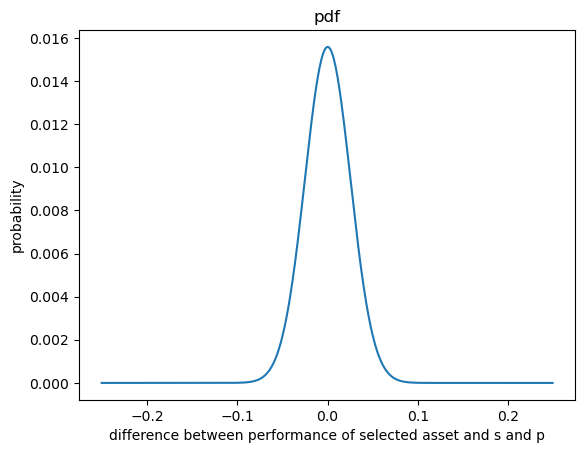

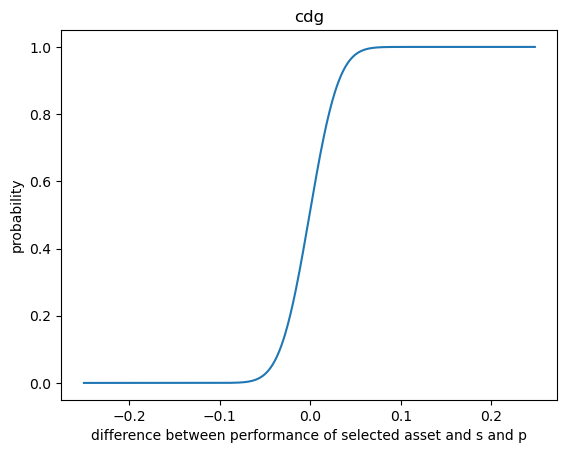

In [14]:
# means = [np.mean(not_null["sp_last_month"]), np.mean(not_null["re_last_month"]), np.mean(not_null["re_sp_2wk_diff"])]
rv = multivariate_normal(mean=means, cov=cov_mat, allow_singular=True)
probs = []
start = -.25
stop = .25
increment = .001
x = np.arange(start, stop, increment)
for val in x:
    # make an array with all the current values
    # insert past month performance
    #"sp", "re", "bnd", "eu", "jp", "gld", future difference
    probs.append(rv.pdf([.017,-.014, -.007,-.018, .025, -.035, val]))
    print(rv.pdf([.017,-.014, -.007,-.018, .025, -.035, val]))


cdf = []
for idx in range(x.size - 1):
    cur_prob = probs[idx]
    next_prob = probs[idx + 1]
    print(cur_prob)
    rieman_sum = min(cur_prob, next_prob) * increment
    rieman_sum += max(cur_prob, next_prob) - min(cur_prob, next_prob) * increment / 2
    if len(cdf) > 0:
        cdf.append(rieman_sum + cdf[-1])
    else:
        cdf.append(rieman_sum)
        
fig1 = plt.figure()
ax = fig1.add_subplot(111)
plt.title("pdf")
plt.xlabel("difference between performance of selected asset and s and p")
plt.ylabel("probability")
ax.plot(x, probs/cdf[-1])
plt.show()

for idx in range(len(cdf)):
    cdf[idx] /= cdf[-1]


fig2 = plt.figure()
ax = fig2.add_subplot(111)
plt.title("cdg")
plt.xlabel("difference between performance of selected asset and s and p")
plt.ylabel("probability")
ax.plot(x[:-1], cdf)
plt.show() 


In [13]:

# find 50% point
cur_prob = 0
idx = 0
while(cur_prob < .5):
    cur_prob = cdf[idx]
    idx += 1
    
print("50 50 change to be above or below")
print(x[idx])


#find expected value
expected_value = 0
for idx in range(len(cdf)):
    if idx == 0:
        expected_value += cdf[idx] * x[idx]
    else:
        cur_prob = cdf[idx - 1]
        next_prob = cdf[idx]
        actual_prob = next_prob - cur_prob
        expected_value += actual_prob * x[idx]
print("Expected Value")
print(expected_value)

50 50 change to be above or below
0.001000000000000223
Expected Value
-0.00042684531527631354
